# Step 0: Defining Model Class

In [82]:
# Basics
import pandas as pd
import numpy as np

#Plotting
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use('ggplot')

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Auto ARIMA
try:
    from pmdarima.arima import auto_arima
except:
    ! pip install pmdarima
    from pmdarima.arima import auto_arima

class Model(object):
    
    def __init__(self, test_size=48, predict_size=60):
        self.model_dictionary = {}
        self.test_size = test_size
        self.predict_size = predict_size
        
    def build_model(self):
        zip_codes = self.model_dictionary.keys()
        N = len(zip_codes)
        for ind, zip_code in enumerate(zip_codes):
            self.select_model(zip_code, trace=False)
            self.predict_in_sample(zip_code)
            self.predict(zip_code)
            print(f'Finished processing {ind+1} out of {N}, zip codes.')
    
    # Load data from data frame
    def load_data(self, df):
        self.make_datetime_index(df)
        for ind in df.index.values:
            row = df.loc[ind]
            zip_code = self.get_zip_code(row)
            row_dict = self.make_row_dict(row)
            self.model_dictionary[zip_code] = row_dict
    
    def make_datetime_index(self, df):
        string_index = df.columns.values[8:]
        self.datetime_index = pd.to_datetime(string_index)
            
    def get_zip_code(self, row):
        return row['RegionName']
            
    def make_row_dict(self, row):
        row_dict = row.iloc[1:8].to_dict()
        time_series = row.iloc[8:]
        df = self.make_time_series_df(time_series)
        df = df.fillna(df.bfill())
        row_dict['TimeSeries'] = df
        return row_dict
      
    def make_time_series_df(self, time_series):
        time_series.index = self.datetime_index
        df = pd.DataFrame(time_series)
        df.columns = ['MedianSales']
        return df
    
    def get_time_series(self, zip_code):
        return self.model_dictionary[zip_code]['TimeSeries']
    
    def get_city_name(self, zip_code):
        return self.model_dictionary[zip_code]['City']
    
    def get_state_abbreviation(self, zip_code):
        return self.model_dictionary[zip_code]['State']
    
    # Train Test Split    
    def make_train_test_split(self, zip_code):
        time_series_df = self.get_time_series(zip_code)
        train = time_series_df[:-self.test_size]
        test = time_series_df[-self.test_size:]
        return train, test
    
    # Plotting
    def make_time_series_plot(self, zip_code, plot_in_sample_prediction=True, prediction=True):
        train, test = self.make_train_test_split(zip_code)
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        fig, ax = plt.subplots(figsize=(8, 5));
        ax.plot(train);
        ax.plot(test);
        legend_labels = ['Train', 'Test']
        try:
            in_sample_prediction = self.get_in_sample_prediction(zip_code)
            ax.plot(in_sample_prediction)
            legend_labels.append('Prediction')
        except:
            pass
        ax.legend(legend_labels);
        ax.set_title(f'Median Sale Price {city_name}, {state_abbreviation} {zip_code}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        return fig
    
    def make_acf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.make_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_acf(
            x=train, 
            ax=ax, 
            lags=100,
            title=f'Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    def make_pacf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.make_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_pacf(
            x=train, 
            ax=ax, 
            lags=100,
            title=f'Partial Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    # Model Selection
    def select_model(self, zip_code, trace=True):
        y = self.get_time_series(zip_code)
        model = auto_arima(
            y = y,
            X=None,
            start_p=0,
            d=1,
            start_q=0,
            max_p=2,
            max_d=2,
            max_q=2,
            start_P=0,
            D=1,
            start_Q=0,
            max_P=2,
            max_D=2,
            max_Q=2,
            max_order=None,
            m=12,
            seasonal=True,
            stationary=False,
            information_criterion='oob',
            alpha=0.05,
            test='kpss',
            seasonal_test='OCSB',
            stepwise=True,            
            suppress_warnings=True,
            error_action='warn',
            trace=trace,
            out_of_sample_size= self.test_size,
            scoring='mse'
        )
        self.model_dictionary[zip_code]['BestModel'] = model
    
    def get_best_model(self, zip_code):
        try:
            best_model = self.model_dictionary[zip_code]['BestModel']
        except:
            self.select_model(zip_code)
            best_model = self.model_dictionary[zip_code]['BestModel']
        return best_model
    
    # Model Validation
    def predict_in_sample(self, zip_code):
        model = self.get_best_model(zip_code)
        time_series = self.get_time_series(zip_code)
        index = time_series.index
        in_sample_prediction = model.predict_in_sample()
        in_sample_prediction_df = pd.DataFrame(in_sample_prediction, index=index)
        in_sample_prediction_df.columns = ['MedianSales']
        self.model_dictionary[zip_code]['InSamplePrediction'] = in_sample_prediction_df
            
    def get_in_sample_prediction(self, zip_code):
        in_sample_prediction = self.model_dictionary[zip_code]['InSamplePrediction']
        return in_sample_prediction
    
    def plot_diagnostics(self, zip_code):
        best_model = self.get_best_model(zip_code)
        city = self.get_city_name(zip_code)
        state = self.get_state_abbreviation(zip_code)
        fig = best_model.plot_diagnostics(figsize=(16, 10));
        fig.suptitle(f'Diagnostics for {city}, {state} {zip_code}', fontsize=16)
        return fig
    
    # Predict future prices
    def predict(self, zip_code):
        model = self.get_best_model(zip_code)
        prediction = model.predict(n_periods=self.predict_size)
        self.model_dictionary[zip_code]['Prediction'] = prediction
        
    def get_prediction(self, zip_code):
        prediction = self.model_dictionary[zip_code]['Prediction']
        return prediction
    
    # Compute ROI
    def compute_roi(self, zip_code):
        initial_price = self.get_time_series(zip_code)['MedianSales'][-1]
        final_price = self.get_prediction(zip_code)[-1]
        roi = (final_price-initial_price)/initial_price
        self.model_dictionary[zip_code]['ROI'] = roi


# Step 1: Import the Data
Our main data set is stored in the `zillow_data.csv` spreadsheet. We load the CSV file as a data frame below.

In [83]:
df = pd.read_csv('../data/ZHVI.csv', index_col='RegionID')
print(df.shape)
df.head()

(30205, 306)


,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,...,930560.0,932099.0,933253.0,930160.0,926279.0,920531.0,919481.0,920766.0,927266.0,932302.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,296113.0,295520.0,...,786707.0,787854.0,789482.0,790451.0,790939.0,791300.0,793322.0,796143.0,801148.0,806603.0
61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,...,1290836.0,1291613.0,1288723.0,1283261.0,1278518.0,1279537.0,1279105.0,1280177.0,1282240.0,1289935.0
91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,203140.0,203391.0,...,340112.0,340320.0,340828.0,341998.0,343077.0,343858.0,344397.0,345495.0,346575.0,348416.0
84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,462086.0,461720.0,...,1010879.0,1012589.0,1014209.0,1015467.0,1015662.0,1017251.0,1020360.0,1023859.0,1029882.0,1036427.0


We will restrict our attention to the city of Baltimore, so we filter the data below.

In [84]:
df = df.query("City == 'Baltimore' and State == 'MD'")
print(df.shape)
df.head()

(20, 306)


,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
RegionID,,,,,,,,,,,,,,,,,,,,,
66825,368,21215,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,80880.0,80666.0,...,141847.0,142485.0,142719.0,143417.0,143771.0,143966.0,144283.0,145614.0,147702.0,150608.0
66834,484,21224,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,93965.0,93858.0,...,181401.0,181205.0,181259.0,181296.0,181779.0,182020.0,182601.0,183819.0,186429.0,189625.0
66828,744,21218,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,71417.0,71853.0,...,158316.0,158647.0,159052.0,159753.0,160528.0,160478.0,160820.0,161670.0,164124.0,166767.0
66816,783,21206,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,82607.0,82660.0,...,157113.0,156408.0,155997.0,155919.0,156004.0,155849.0,156458.0,158033.0,160752.0,163549.0
66839,1088,21229,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,82654.0,82794.0,...,120521.0,121307.0,121899.0,122483.0,123296.0,124109.0,125143.0,126557.0,129136.0,131301.0


# Step 2: Instantiate the Model and Load in the Data
Below we instantiate a Model object and load our selected data into the object.

In [85]:
model = Model()
model.load_data(df)
model.build_model()

Finished processing 0 out of 20, zip codes.
Finished processing 1 out of 20, zip codes.
Finished processing 2 out of 20, zip codes.
Finished processing 3 out of 20, zip codes.
Finished processing 4 out of 20, zip codes.
Finished processing 5 out of 20, zip codes.
Finished processing 6 out of 20, zip codes.
Finished processing 7 out of 20, zip codes.
Finished processing 8 out of 20, zip codes.
Finished processing 9 out of 20, zip codes.
Finished processing 10 out of 20, zip codes.
Finished processing 11 out of 20, zip codes.
Finished processing 12 out of 20, zip codes.
Finished processing 13 out of 20, zip codes.
Finished processing 14 out of 20, zip codes.
Finished processing 15 out of 20, zip codes.
Finished processing 16 out of 20, zip codes.
Finished processing 17 out of 20, zip codes.
Finished processing 18 out of 20, zip codes.
Finished processing 19 out of 20, zip codes.


# Step 3: EDA and Visualization
Below we display a time series plot, ACF plot, and PACF plot for the zip code 21215. The class methods used below will work for any zip code in our model.

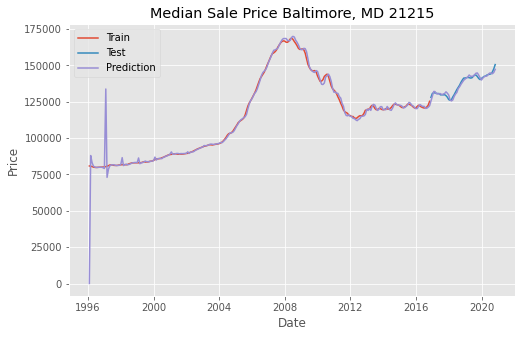

In [86]:
model.make_time_series_plot(21215);

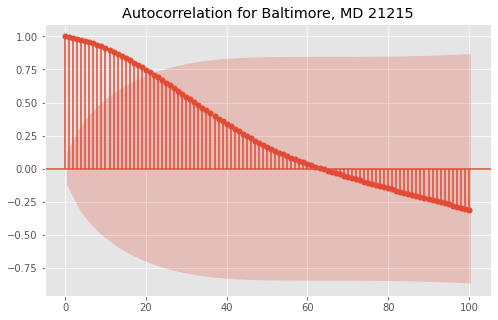

In [73]:
model.make_acf_plot(21215);

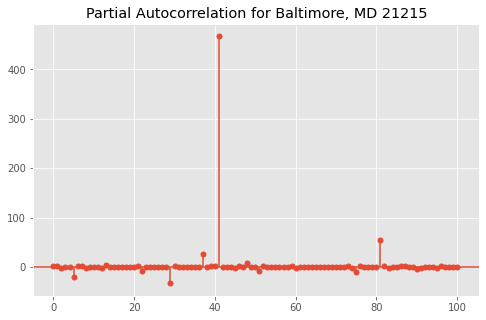

In [74]:
model.make_pacf_plot(21215);

# Step 4: ARIMA Modeling

In [75]:
model.select_model(21215)

Performing stepwise search to minimize oob
 ARIMA(0,1,0)(0,1,0)[12]             : OOB=41930794.583, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : OOB=36724894.565, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : OOB=41864736.680, Time=0.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : OOB=25964720.241, Time=0.33 sec
 ARIMA(1,1,0)(0,1,1)[12]             : OOB=37376310.661, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : OOB=34044100.575, Time=0.78 sec
 ARIMA(2,1,0)(0,1,0)[12]             : OOB=22140718.789, Time=0.40 sec
 ARIMA(2,1,0)(1,1,0)[12]             : OOB=31062139.807, Time=1.11 sec
 ARIMA(2,1,0)(0,1,1)[12]             : OOB=31707218.831, Time=1.02 sec
 ARIMA(2,1,0)(1,1,1)[12]             : OOB=46002919.545, Time=1.88 sec
 ARIMA(2,1,1)(0,1,0)[12]             : OOB=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,1,0)[12]             : OOB=23209432.257, Time=0.60 sec
 ARIMA(2,1,0)(0,1,0)[12] intercept   : OOB=12534780.142, Time=0.61 sec
 ARIMA(2,1,0)(1,1,0)[12] intercept   : OOB=

# Step 5: Interpreting Results

In [76]:
model.predict_in_sample(21215)

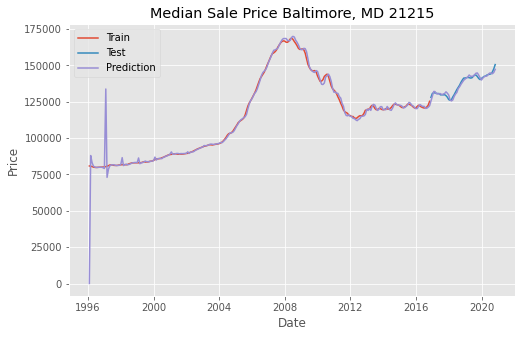

In [77]:
model.make_time_series_plot(21215);

In [78]:
model.predict(21215)

In [79]:
model.compute_roi(21215)

0.38550107828388086

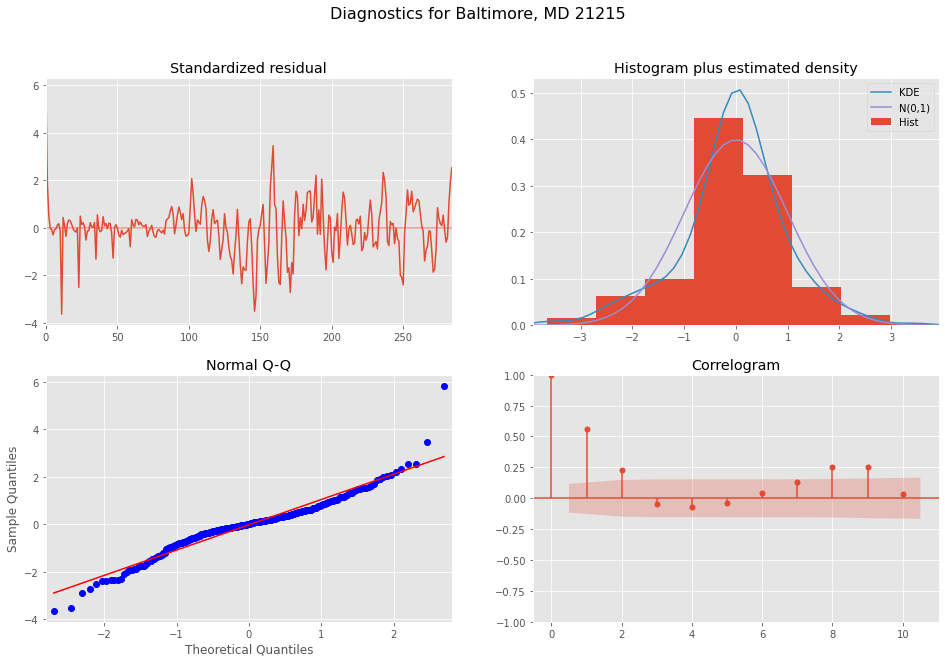

In [80]:
model.plot_diagnostics(21215);

In [87]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model.model_dictionary, f)